In [1]:
from data import *
from models import *
import json
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)    
pd.set_option('display.max_colwidth', 100)    

%load_ext autoreload
%autoreload 2

data_path = os.getcwd() + "/data"

## DATA

In [2]:
kb_file = os.path.join(data_path,'kb_question.csv')
if os.path.exists(kb_file):
    kb_question = pd.read_csv(kb_file)
else:
    kb_question = read_kb(data_path)
    kb_question.to_csv(kb_file , index=False, encoding='utf-8-sig')

In [3]:
# display(kb_question.sample(n=100))

In [4]:
# train_question, dev_question, test_question = np.split(kb_question.sample(frac=1), [int(.8*len(kb_question)), int(.9*len(kb_question))])

In [5]:
# kb_question_pairs_dfs = {}
# for data_type in ['train', 'dev', 'test']:
#     filename = data_type+".csv"
#     if not os.path.exists(os.path.join(data_path,filename)):
#         df = create_pair_data(eval(data_type+"_question"))
#         df.to_csv(os.path.join(data_path, filename), index=False, header=False, encoding='utf_8_sig')

#     kb_question_pairs_dfs[data_type] = pd.read_csv(os.path.join(data_path, filename), header=None, names=['s1', 's2', 'score'])
#     kb_question_pairs_dfs[data_type]['label'] = kb_question_pairs_dfs[data_type]['score'].apply(lambda x: int(x/2))

In [6]:
train_pairs, dev_pairs, test_pairs = get_question_pairs(data_path)

processing /home/tingchunyeh/Sentence_sim/data/train.csv ...
** TRAIN DATA : Found 1446025 pairs of train sentences.
processing /home/tingchunyeh/Sentence_sim/data/dev.csv ...
** DEV DATA : Found 148063 pairs of dev sentences.
processing /home/tingchunyeh/Sentence_sim/data/test.csv ...
** TEST DATA : Found 148010 pairs of test sentences.


In [7]:
sentences = np.append(train_pairs['s1'], train_pairs['s2'])

In [8]:
if not os.path.exists(os.path.join(data_path,'word2ind.pickle')):
    word2ind, ind2word = get_word2ind_ind2word(sentences, min_n=5)
    with open( os.path.join(data_path, "word2ind.pickle" ), 'wb') as handle:
        pickle.dump(word2ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open( os.path.join(data_path, "ind2word.pickle" ), 'wb') as handle:
        pickle.dump(ind2word, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
    ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )

In [9]:
wv, default_wv = build_vocab(sentences, "w2v-model.txt")
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")
# word_embed_matrix = build_word_embed_matrix(word2ind, word_embed_dim=150)

Found (5201/5757) words with w2v vectors
vocab size: 5757
Found (5211/5768) words with w2v vectors


## TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [15]:
def TF_IDF_train(txt, min_df=5):
    tf = TfidfVectorizer(norm=None,  min_df=min_df)
    txt_fitted = tf.fit(txt)
    idf = dict(zip(txt_fitted.get_feature_names(), tf.idf_))    
    return txt_fitted, idf

In [16]:
def TF_IDF_predict(s1, s2):
    tfidf1 = txt_fitted.transform([s1])
    tfidf2 = txt_fitted.transform([s2])
    return cosine_similarity(tfidf1, tfidf2)[0][0]

In [18]:
txt_fitted, idf = TF_IDF_train(sentences)
print("Vocabulary size: {}".format(len(idf)))

Vocabulary size: 4768


## Avg word embedding

In [23]:
def avg_embedding(sentence):
    return np.mean([wv[w] if w in wv else default_wv for w in sentence.split(" ")], axis=0)

In [24]:
def avg_embedding_predict(s1, s2):
    avg_embed1 = avg_embedding(s1)
    avg_embed2 = avg_embedding(s2)
    return cosine_similarity([avg_embed1], [avg_embed2])[0][0]

## IDF word embedding

In [26]:
def IDF_embedding(sentence):
    res = np.zeros(300)
    count = 0
    for w in sentence.split():
        if w in wv:
            cur = wv[w]*idf[w] if w in idf else wv[w] 
        else:
            cur = default_wv
        res = np.add(res, cur)
        count += 1
    return res/count

In [27]:
def IDF_embedding_predict(s1, s2):
    IDF_embed1 = IDF_embedding(s1)
    IDF_embed2 = IDF_embedding(s2)
    return cosine_similarity([IDF_embed1], [IDF_embed2])[0][0]

## Evaluation

In [204]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues): 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def predict(s1_ls, s2_ls, ptype='TF_IDF_predict'):
    preds = []
    for idx in tqdm(range(len(s1_ls))):
        s1, s2 = s1_ls[idx], s2_ls[idx]
        preds.append(eval(ptype)(s1, s2))
    return preds

def get_labels(preds, ths=[0.5, 0.7]):
    labels = []
    for pred in preds:
        if pred<ths[0]:
            labels.append(0)
        elif pred<ths[1]:
            labels.append(1)
        else:
            labels.append(2)
    return labels    
    
def eval_plot(pred_labels, true_labels):
    cnf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix, without normalization')
    plt.subplot(1,2,2)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix', normalize=True)
    plt.subplots_adjust(wspace = 0.2)
    plt.show()
    
    
val_acc_best = -1e10
def evaluate(data_pairs, bsize = 64):
    nli_net.eval()
    correct = 0.0
    global val_acc_best
    
    s1 = data_pairs['s1'] 
    s2 = data_pairs['s2'] 
    target = data_pairs['label'] 
    labels = np.array([])

    for i in tqdm(range(0, len(s1), bsize)):
        # prepare batch
            
        s1_batch, s1_len = get_inds_batch(s1[i: i+bsize], word2ind)
        s2_batch, s2_len = get_inds_batch(s2[i: i+bsize], word2ind)
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i: i+bsize])).cuda()

        # model forward
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()
        labels = np.append(labels, pred.cpu().data.numpy())

    eval_acc = round(100 * correct / len(s1), 2)        
    return labels

def pred_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    pred = output.data.max(1)[1]
    return pred.item()

def score_onePair(s1, s2):
    nli_net.eval()
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    return output.cpu().data[0][2].item()

def encode_sentence(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    if next(nli_net.parameters()).is_cuda:
        s_batch = Variable(s_batch.cuda())
    else:
        s_batch = Variable(s_batch)
    encode = nli_net.encode((s_batch, s_len))
    return encode.cpu().data[0]

def encode_sentence_with_weight(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    if next(nli_net.parameters()).is_cuda:
        s_batch = Variable(s_batch.cuda())
    else:
        s_batch = Variable(s_batch)
    encode = nli_net.encode((s_batch, s_len))
    return encode.cpu().data[0], weight.cpu().data[0]

def cosScore_onePair(s1, s2):
    arr1 = encode_sentence(s1).reshape(1, -1)
    arr2 = encode_sentence(s2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

### TF-IDF

In [30]:
TFIDF_preds = predict(dev_pairs['s1'], dev_pairs['s2'])

100%|██████████| 148063/148063 [10:46<00:00, 228.85it/s]


overall accuracy: 0.5849807176674794


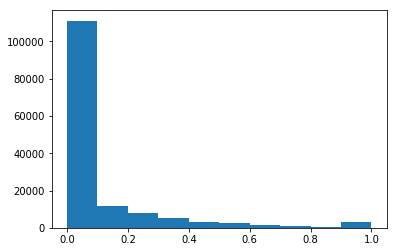

Confusion matrix, without normalization
[[60799  3005  3056]
 [32531  3116 11180]
 [10187  1490 22699]]
Normalized confusion matrix
[[0.90934789 0.04494466 0.04570745]
 [0.69470605 0.06654281 0.23875115]
 [0.29634047 0.04334419 0.66031534]]


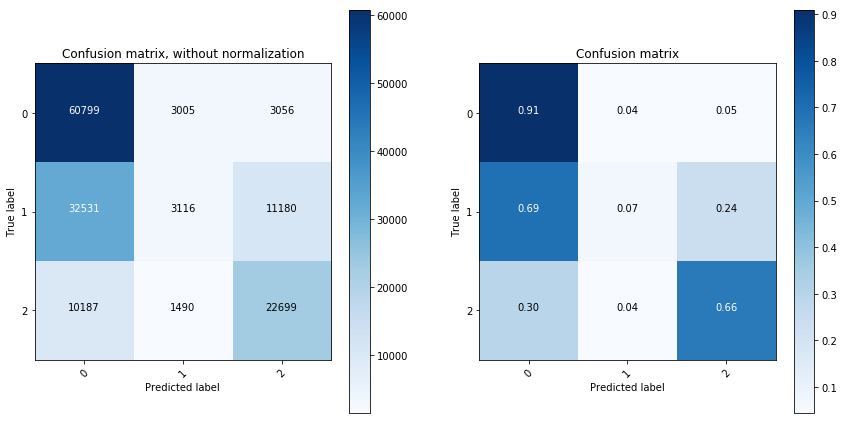

In [116]:
TFIDF_pred_labels = get_labels(TFIDF_preds, ths=[0.01, 0.1])
print("overall accuracy:", float(np.where(TFIDF_pred_labels==dev_pairs['label'])[0].shape[0])/len(TFIDF_pred_labels))
plt.figure()
plt.hist(TFIDF_preds)
plt.show()
eval_plot(TFIDF_pred_labels, dev_pairs['label'])

### avg word embedding

In [45]:
avg_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="avg_embedding_predict")

100%|██████████| 148063/148063 [02:19<00:00, 1063.90it/s]


overall accuracy: 0.5727156683303729


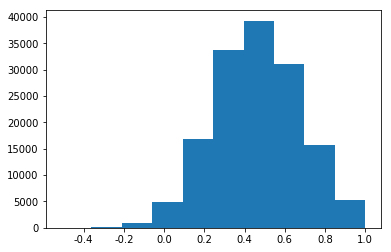

Confusion matrix, without normalization
[[53292  5272  8296]
 [24951  5259 16617]
 [ 5989  2140 26247]]
Normalized confusion matrix
[[0.7970685  0.07885133 0.12408017]
 [0.53283362 0.112307   0.35485938]
 [0.17422039 0.06225273 0.76352688]]


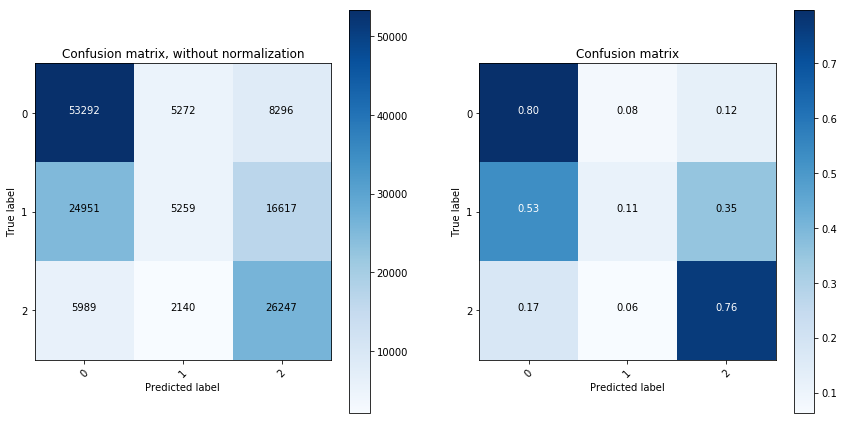

In [115]:
avg_embed_pred_labels = get_labels(avg_embed_preds, ths=[0.5, 0.55])
print("overall accuracy:", float(np.where(avg_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(avg_embed_pred_labels))
plt.figure()
plt.hist(avg_embed_preds)
plt.show()
eval_plot(avg_embed_pred_labels, dev_pairs['label'])

### IDF word embedding

In [50]:
IDF_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="IDF_embedding_predict")

100%|██████████| 148063/148063 [02:23<00:00, 1032.21it/s]


0.5529335485570331


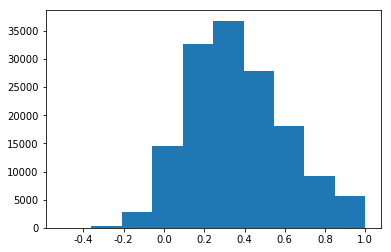

Confusion matrix, without normalization
[[45174 11673 10013]
 [15982  8856 21989]
 [ 3432  3105 27839]]
Normalized confusion matrix
[[0.67565061 0.17458869 0.14976069]
 [0.34129882 0.18912166 0.46957952]
 [0.0998371  0.09032465 0.80983826]]


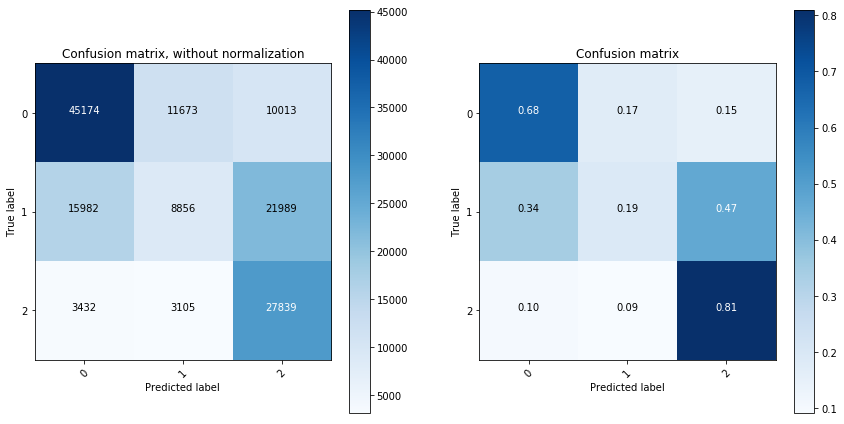

In [114]:
IDF_embed_pred_labels = get_labels(IDF_embed_preds, ths=[0.3, 0.4])
print( float(np.where(IDF_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(IDF_embed_pred_labels))
plt.figure()
plt.hist(IDF_embed_preds)
plt.show()
eval_plot(IDF_embed_pred_labels, dev_pairs['label'])

### InferSent Train

In [11]:
from torch import optim

def adjust_learning_rate(optimizer):
    print("learning rate decay by half")
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
        param_group['lr'] /= 2
        print(param_group['lr'])

def train_small_epoch(epochs=1, batch_size=64, dpout_embed=0.2, percent=0.1, verbose=False):
    all_costs = []
    tot_costs = []
    logs = []
    correct = 0.0
    nli_net.train()
    permutation = np.random.choice(np.random.permutation(len(train_pairs['s1'])), int(percent*len(train_pairs['s1'])))
    s1 = train_pairs['s1'][permutation]
    s2 = train_pairs['s2'][permutation]
    target = train_pairs['label'][permutation]

    for i in range(0, len(s1), batch_size):
        s1_batch, s1_len= get_inds_batch(s1[i:i+batch_size], word2ind)
        s2_batch, s2_len= get_inds_batch(s2[i:i+batch_size], word2ind)
    
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i:i+batch_size])).cuda()
        
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
        
        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

        # loss
        loss = loss_fn(output, tgt_batch)
        all_costs.append(loss.item())
        tot_costs.append(loss.item())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and len(all_costs) == 10:
            logs.append('{0};  loss: {1};  accuracy train: {2}'.format(i, 
                            round(np.mean(all_costs), 2), round(100.*correct/(i+k), 2)))
            print(logs[-1])
            all_costs = []
            
    train_acc = round(100 * correct/len(s1), 2)
    train_loss = round(np.mean(tot_costs), 2)
    return train_loss, train_acc  

In [272]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  300,
    'enc_hidden_dim'   :  256,
    'num_layer'      :  1,
    'dpout_model'    :  0,
    'dpout_fc'       :  0.2,
    'fc_dim'         :  256,
    'bsize'          :  64,
    'n_classes'      :  3,
    'pool_type'      :  'max',
    'encoder_type'   :  'GRUEncoder',
    'use_cuda'       :  True,
    'dpout_embed'    :  0.2,
    'embed_freeze'   :  False,
    'embed_matrix'   :  word_embed_matrix,
    'weight_decay'   :  1e-5,
    "use_attention": True,
}

In [273]:
torch.manual_seed(10)
np.random.seed(10)

### Train Playground

In [277]:
from models import *
nli_net = NLINet(config_nli_model)
parameters = nli_net.parameters()
# parameters = filter(lambda p: p.requires_grad, nli_net.parameters())
print(nli_net)

# loss 
weight = torch.FloatTensor(3).fill_(1)
loss_fn = nn.CrossEntropyLoss(weight=weight)

# optimizer
optimizer = optim.Adam(parameters, lr=0.005, weight_decay=config_nli_model['weight_decay'])

# cuda 
torch.cuda.manual_seed(10)
torch.cuda.set_device(0)
nli_net.cuda()
loss_fn.cuda()

NLINet(
  (embed): Embedding(5769, 300)
  (embed_dropout): Dropout(p=0.2)
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, bidirectional=True)
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.2)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)


CrossEntropyLoss()

In [285]:
percent = 0.001
batch_size = 64
dpout_embed = 0.2

nli_net.train()
permutation = np.random.choice(np.random.permutation(len(train_pairs['s1'])), int(percent*len(train_pairs['s1'])))
s1 = train_pairs['s1'][permutation]
s2 = train_pairs['s2'][permutation]
target = train_pairs['label'][permutation]
prev_loss = float('inf')
tot_loss = []

for epoch in tqdm(range(1)):
    for stidx in range(0, len(s1), batch_size):
        s1_batch, s1_len= get_inds_batch(s1[stidx:stidx+batch_size], word2ind)
        s2_batch, s2_len= get_inds_batch(s2[stidx:stidx+batch_size], word2ind)

        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[stidx:stidx+batch_size])).cuda()
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        
        # loss
        loss = loss_fn(output, tgt_batch)
        tot_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        
        for name, param in nli_net.named_parameters():
            print(name, param.grad)
        optimizer.step()
        break
        # gradient clipping
    #     for p in parameters:
    #         print(p.grad.norm())
    #     print(nn.utils.clip_grad_norm_(nli_net.parameters(), 1.0, norm_type=2))


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

embed.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0001, -0.0001,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0001, -0.0000,  ...,  0.0003,  0.0001, -0.0001],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
encoder.enc_lstm.weight_ih_l0 tensor([[ 6.0638e-06, -6.0597e-06, -7.8795e-06,  ..., -2.5426e-06,
          2.4515e-05, -1.0657e-05],
        [-4.7942e-05, -1.4423e-05,  3.4767e-05,  ..., -1.1004e-05,
         -7.9003e-05,  1.0614e-05],
        [ 3.6102e-05, -2.7818e-05, -5.9714e-05,  ..., -4.2557e-05,
          2.3295e-05,  7.5104e-05],
        ...,
        [ 1.6673e-04, -2.4533e-04, -2.2330e-04,  ..., -2.4740e-04,
          3.1533e-04,  5.2749e-05],
        [-1.0862e-04,  2.4100e-04,  4.4099e-05,  ...,  1.6700e-04,
       

### Find Best Parameters

In [588]:
# lrs = []
# hidden_sizes = []
# train_losses = []
# weight_decays = []
# train_accs = []
# for i in range(30):
#     lr = 10**np.random.uniform(-1, -4.5)
#     hidden_size = np.random.choice([128, 256, 512])
#     weight_decay = 10**np.random.uniform(-4, -7)
#     lrs.append(lr)
#     hidden_sizes.append(hidden_size)
#     weight_decays.append(weight_decay)
    
#     config_nli_model['enc_lstm_dim'] = int(hidden_size)
#     config_nli_model['weight_decay'] = weight_decay
    
#     from models import *
#     nli_net = NLINet(config_nli_model)
#     parameters = filter(lambda p: p.requires_grad, nli_net.parameters())

#     optimizer = optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
#     weight = torch.FloatTensor(3).fill_(1)
#     loss_fn = nn.CrossEntropyLoss(weight=weight)
    
#     nli_net.cuda()
#     loss_fn.cuda()
#     for i in range(5):
#         train_loss, train_acc  = train_small_epoch(1, batch_size=64, dpout_embed=0.2, percent=0.01)
#         print("lr: {};  hidden_size: {};  train_loss: {};  train_acc: {}".format(round(lr,5), hidden_size, train_loss, train_acc))
#     print("-"*100)
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)

### InferSent Eval

In [376]:
model_name = "model_24"
with open(os.path.join("saved_model", model_name, "config.json"), "rb") as handle:
    params = json.loads(handle.read())
word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")

Found (5211/5768) words with w2v vectors


In [377]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  word_embed_matrix.shape[1],
    'enc_hidden_dim'   :  params['enc_hidden_dim'],
    'num_layer'      :  params['num_layer'],
    'dpout_model'    :  params['dpout_model'],
    'dpout_fc'       :  params['dpout_fc'],
    'fc_dim'         :  params['fc_dim'],
    'bsize'          :  params['batch_size'],
    'n_classes'      :  params['n_classes'],
    'pool_type'      :  params['pool_type'],
    'encoder_type'   :  params['encoder_type'],
    'use_cuda'       :  params['use_cuda']==1,
    'dpout_embed'    :  params['dpout_embed'],
    'embed_freeze'   :  params['embed_freeze'],
    'embed_matrix'   :  word_embed_matrix,
    "use_attention": params['use_attention'],
}


In [378]:
torch.cuda.set_device(0)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [379]:
from models import *
nli_net = NLINet(config_nli_model)
nli_net.load_state_dict(torch.load(os.path.join("saved_model", model_name, model_name)))
if config_nli_model['use_cuda']:
    nli_net.cuda()
print("model structure: \n", nli_net)
print("model parameters: \n", params)

model structure: 
 NLINet(
  (embed): Embedding(5769, 300)
  (embed_dropout): Dropout(p=0.2)
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.4)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)
model parameters: 
 {'data_path': 'data', 'encoder_type': 'GRUEncoder', 'enc_hidden_dim': 256, 'num_layer': 2, 'fc_dim': 256, 'n_classes': 3, 'pool_type': 'max', 'use_cuda': 1, 'use_attention': 0, 'n_epochs': 10, 'batch_size': 64, 'dpout_model': 0.3, 'dpout_fc': 0.4, 'dpout_embed': 0.2, 'embed_freeze': False, 'lr': 0.0002, 'last_model': '', 'saved_model_name': 'model_24', 'w2v_model': 'w2v-model.txt', 'weight_decay': 0.0, 'lr_decay_th': 0.005}


In [347]:
eval_labels = evaluate(dev_pairs, bsize = 64)

100%|██████████| 2314/2314 [00:26<00:00, 86.83it/s]


0.911213469941849
Confusion matrix, without normalization
[[63752  2439   669]
 [ 3891 40721  2215]
 [ 1996  1936 30444]]
Normalized confusion matrix
[[0.95351481 0.03647921 0.01000598]
 [0.08309309 0.86960514 0.04730177]
 [0.05806377 0.05631836 0.88561787]]


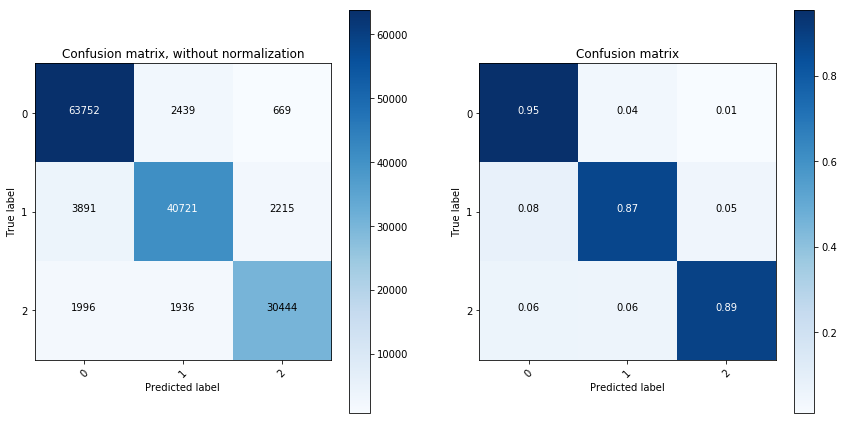

In [348]:
print( float(np.where(eval_labels==dev_pairs['label'])[0].shape[0])/len(eval_labels))
eval_plot(eval_labels, dev_pairs['label'])

## Error Analysis

In [916]:
start_time = time.time()
n = 15
s = ["我 想 把 地址 改 到 北京"]
for i in range(n):
    _ = cosScore_onePair(["哪款 热水器 好"], ["能 推荐 一个 热水器"])
time_consume = time.time() - start_time
print(time_consume)

0.22003650665283203


In [906]:
s1 = "哪款 热水器 好"
s2 = "能 推荐 一个 热水器"
s3 = "能 推荐 一个 电视"
s4 = "我 想买 热水器"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))

2
2
2


In [521]:
s1 = "我 想 把 地址 改 到 北京"
s2 = "地址 能 改 到 北京"
s3 = "地址 能 改 到 天津"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
2


In [522]:
s1 = "我 把 地址 改 到 北京"
s2 = "能 推荐 热水器"
s3 = "我 退货"
s4 = "可以 改 退货 地址"
s6 = "我 改 退货 地址"

print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))
print(pred_onePair([s1], [s6]))
print(pred_onePair([s4], [s6]))

0
2
2
2
2


In [523]:
inds = np.where((eval_labels==0) & (dev_pairs['label']==2))[0]
for ind in inds:
    print(dev_pairs['s1'][ind],"\t", dev_pairs['s2'][ind])

券 怎么 没有 到账 	 买 苏泊尔 返 100 是 返 问地点 账户 怎么 没有
券 怎么 没有 到账 	 怎么 现在 没有 返回
一 小 时 太 慢 我 要 问时间 前 买 问时间 到 	 有 什么 券 送 时 送给 我
我 买 参加 问时间 退换货 365天 换 不 要 看 	 365
芳村 能 到 	 在 上海 买 能 到 江苏 泰州
芳村 能 到 	 负责 搬 楼
我 手机 问时间 能 送 单 	 有 什么 券 送 时 送给 我
我 手机 问时间 能 送 单 	 我 壳 问时间 发还 有 商品
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 通电 指示灯 不亮 怎么 处理
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 有 人 来 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 要 保修 怎 办
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 你 卡 现在 插 手机 里 不显示
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 海外购 商品 故障 怎么 保修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 小米 平衡 车 不能 激活 是什么 原因
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 商品 突然 做 不了 饭
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 报 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 买 海尔 冰箱 故障 怎么 弄 修 货
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 怎么 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 问时间 买 手机 为什么 再 关机 状态 下 不能 充满 格
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 售后 怎么 安排
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 显示屏 不能 说 安排 维修 师傅 上门
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 台 商品 怎么 突然 不能 单 脱水
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 去年 买 电饭煲 故障 去 问地点 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 打印机 卡纸 要 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 前 问时间 买 热

我 订 松下 冰箱 能 延迟 到 问时间 发货 	 苏宁 苏宁 物流 能 放在 门卫 代收
海外购 商品 故障 怎么 保修 	 复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么
海外购 商品 故障 怎么 保修 	 小米 平衡 车 不能 激活 是什么 原因
是 发 顺丰 	 苏宁配
看下 订单 怎么 只 发 一袋 米 	 怎么 送 别的 牌子
看下 订单 怎么 只 发 一袋 米 	 我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡
看下 订单 怎么 只 发 一袋 米 	 商品 到 和 买 数量 有误
苏宁 支付 说 账户 冻结 怎么 解冻 	 说 帐 号 被 冻 洁
乐 2 prox 620 手机 标准 是 移动 联通 电信 三 卡 都 用 	 在吗 p 20 用
乐 2 prox 620 手机 标准 是 移动 联通 电信 三 卡 都 用 	 该机 没有 负责 和 鼠标
乐 2 prox 620 手机 标准 是 移动 联通 电信 三 卡 都 用 	 漫步者 商品 华硕 都 不能用
周 降 	 我 问时间 花 269元 买 8203 问时间 199元
显示屏 不能 说 安排 维修 师傅 上门 	 净化器 总 是 状态 什么 情况
显示屏 不能 说 安排 维修 师傅 上门 	 复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么
显示屏 不能 说 安排 维修 师傅 上门 	 我 显卡 不显示 怎么
显示屏 不能 说 安排 维修 师傅 上门 	 你 卡 现在 插 手机 里 不显示
显示屏 不能 说 安排 维修 师傅 上门 	 小米 平衡 车 不能 激活 是什么 原因
只 说 问时间 能 到达 	 有 什么 券 送 时 送给 我
只 说 问时间 能 到达 	 我 壳 问时间 发还 有 商品
赠品 不要 价格 能 优惠 	 现在 买 会 降
赠品 不要 价格 能 优惠 	 因为 商品 降
有 宝宝 辅食 销售 	 找 一些纸 尿裤 给我
我 账户 冻结 没有 解决 	 说 帐 号 被 冻 洁
自助 申请 退换货 处理 时 	 我 商品 有 故障 你 工作 人员 已经 看 过 问时间 有 结果 天气 越来越 热 家里 没有 商品 孩子 都 生病
怎么 预约 维修 	 复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么
怎么 预约 维修 	 小米 平衡 车 不能 激活

为什么 给我 东西 与 实物 不符 	 冰箱 页面 介绍 是 1级 到 是 2级 你 虚假 宣传
费洛仕 衣服 是 苏宁 物流 	 苏宁配
费洛仕 衣服 是 苏宁 物流 	 我 看 是 你 物 流速 度
联系 海尔 商家 来 维修 冰箱 	 复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么
是什么 0元购 优惠 	 我 买 400 东西 怎么 只 返 给我 300元 券
机 牌 是什么 用 	 登机 卡 是什么
都 家 买 什么 优惠 不 	 我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到
都 家 买 什么 优惠 不 	 是否 能 议价
怎么 看 	 这边 能 给 检测 下 是 问地点 故障
怎么 看 	 必须 到 看 点 检测
怎么 看 	 问地点 检测
问时间 转账 到 现在 没有 到账 	 把 名字 字 写 错
超时 发货 怎么 赔偿 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
维修 怎么 申请 	 我 商品 突然 做 不了 饭
维修 怎么 申请 	 小米 平衡 车 不能 激活 是什么 原因
送 修 问地点 和 联系 是 哪 	 商家 客服 联系 有货
好的 有 我 货 没有 到 问时间 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
好的 有 我 货 没有 到 问时间 	 怎么 没有 从 郑州 发出
物流 师傅 说 脏话 	 我 没有 要 退换货 正常 发货
我 买 遥控器 为什么 着 没反应 	 商品 安装 好 开 不了
买 订单 保持 问时间 	 我 在 网页 支付 没有 体现 我 必须 15分钟 支付
买 订单 保持 问时间 	 你 线上 规 定 我 15分钟 支付
你 卡 现在 插 手机 里 不显示 	 申请 维修
你 卡 现在 插 手机 里 不显示 	 我 微波炉 故障 怎么 维修
你 卡 现在 插 手机 里 不显示 	 售后 找 谁
你 卡 现在 插 手机 里 不显示 	 海外购 商品 故障 怎么 保修
你 卡 现在 插 手机 里 不显示 	 显示屏 不能 说 安排 维修 师傅 上门
你 卡 现在 插 手机 里 不显示 	 我 买 海尔 冰箱 故障 怎么 弄 修 货
你 卡 现在 插 手机 里 不显示 	 售后 是 苏宁 直接 负责
你 卡 

## Test Set

In [380]:
def nn_score(df):
    print("caculating neural netowrk prediction ...")
    df['nn_score'] = df[['q_tokens', 'similar_q_tokens']].apply(lambda x: score_onePair([x[0]],[x[1]]), axis=1)
    df['nn_roundScore'] = df['nn_score'].apply(lambda x: round(x, 3))

def cos_score(df):
    print("calculating cosine similarity of encoding vector ...")
    df['cos_score'] = df[['q_tokens', 'similar_q_tokens']].apply(lambda x: cosScore_onePair([x[0]],[x[1]]), axis=1)
    df['cos_roundScore'] = df['cos_score'].apply(lambda x: round(x, 3))

def result_label(df):
    nn_idx = df.groupby('q_id')['nn_score'].transform(max) == df['nn_score']
    sm_idx = df.groupby('q_id')['score'].transform(max) == df['score']
    cos_idx = df.groupby('q_id')['cos_score'].transform(max) == df['cos_score']
    
    nn_label = df.loc[nn_idx].groupby('q_id')[['similar_q', 'similar_q_tokens', 'standard_q', 'nn_roundScore']].first()
    sm_label = df.loc[sm_idx].groupby('q_id')[['similar_q', 'similar_q_tokens','standard_q', 'score']].first()
    cos_label = df.loc[cos_idx].groupby('q_id')[['similar_q', 'similar_q_tokens','standard_q', 'cos_roundScore']].first()
    
    q = df.groupby('q_id')[['q', 'expect_q', 'q_tokens']].first()
    result = pd.concat( [q, sm_label, nn_label, cos_label], axis=1)
    result.columns = ['q', 'expect_q', 'q_tokens', 
                      'sm_similar_q', 'sm_similar_q_tokens', 'sm_standard_q', 'sm_score', 
                      'nn_similar_q', 'nn_similar_q_tokens', 'nn_standard_q', 'nn_score',
                     'cos_similar_q', 'cos_similar_q_tokens', 'cos_standard_q', 'cos_score']
    return result

def major_vote(s_ls):
    count = collections.defaultdict(int)
    for s in s_ls:
        count[s] += 1
    sorted_count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
    if sorted_count[0][1]>1:
        return sorted_count[0][0]
    else:
        return s_ls[-1]
    
def major_label(df):
    df['major_standard_q'] = df[['sm_standard_q', 'nn_standard_q', 'cos_standard_q']].apply(lambda x: major_vote(x),axis=1)
    
def q_num_tokens(df):
    df['q_num_tokens'] = df['q_tokens'].apply(lambda x: len(x.strip().split()))

In [381]:
test_df = pd.read_csv( os.path.join(data_path, "questions_test_tokenized.csv"))
nn_score(test_df)
cos_score(test_df)
test_df.to_csv(os.path.join( "result" , "questions_test_pred_" + model_name + ".csv"), index=False, encoding='utf-8-sig')

caculating neural netowrk prediction ...
calculating cosine similarity of encoding vector ...


In [20]:
# 1, 11, 20, 21, 22

In [382]:
model_name = "model_24"
test_df = pd.read_csv(os.path.join( "result" ,"questions_test_pred_"+model_name+".csv"))

In [383]:
# display(test_df.head())

In [384]:
test_result_df = result_label(test_df)
major_label(test_result_df)

In [385]:
# similar_topics = {
#     "什么时候送": ["什么时候送", "下单多久发货", "商户商品多久发货", "查询送货"], #, "为什么还没送到"
#     "申请退换货": ["申请退换货", "如何申请退货", "申请换货"],
#     "申请售后": ["申请售后", "如何预约维修", "售后维保地址电话"],
#     "什么时候上门安装": ["什么时候上门安装", "安装为什么一直没来呢"],
#     "保修需要发票吗？": ["保修需要发票吗？", "发票丢失或没有保修卡支持保修吗"],
#     "怎么预约安装": ["怎么预约安装", "如何预约安装"], 
#     "怎么开发票": ["怎么开具发票？", "怎么开发票"],
#     "电子发票怎么下载（无下载按钮怎么办）": ['电子发票怎么下载（无下载按钮怎么办）', "电子发票怎么下载"],
# }
# synonym_topics = {}
# for key, items in similar_topics.items():
#     for item in items:
#         synonym_topics[item] = key

# test_result_df['expect_q'] = test_result_df['expect_q'].apply(lambda x: synonym_topics[x] if x in synonym_topics else x)
# test_result_df['cos_standard_q'] = test_result_df['cos_standard_q'].apply(lambda x: synonym_topics[x] if x in synonym_topics else x)
# test_result_df['nn_standard_q'] = test_result_df['nn_standard_q'].apply(lambda x: synonym_topics[x] if x in synonym_topics else x)
# test_result_df['sm_standard_q'] = test_result_df['sm_standard_q'].apply(lambda x: synonym_topics[x] if x in synonym_topics else x)

In [386]:
# display(test_result_df.sample(30))

In [387]:
print( (test_result_df.sm_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.nn_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.cos_standard_q==test_result_df.expect_q).mean() )
print( (test_result_df.major_standard_q==test_result_df.expect_q).mean() )
print( ( (test_result_df.sm_standard_q==test_result_df.expect_q) | \
        (test_result_df.nn_standard_q==test_result_df.expect_q)  | \
        (test_result_df.cos_standard_q==test_result_df.expect_q)).mean() )

0.6462440063931806
0.6515716568993074
0.6856686201385189
0.6899307405434204
0.7597229621736814


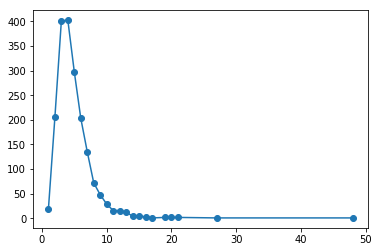

In [388]:
q_num_tokens(test_result_df)
test_result_df.q_num_tokens.value_counts().sort_index().plot(marker='o')
plt.show()

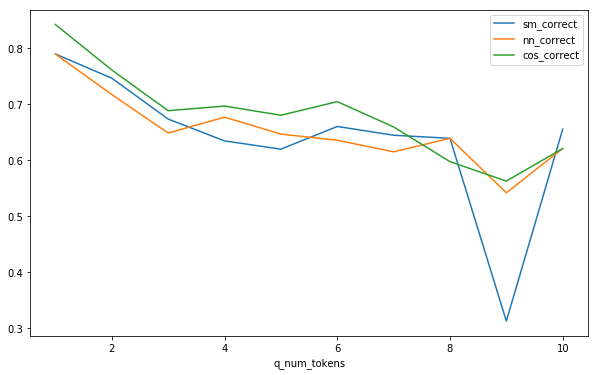

In [389]:
test_result_short_df = pd.DataFrame(test_result_df[test_result_df.q_num_tokens<=10])
test_result_short_df['sm_correct'] = test_result_short_df[['expect_q', 'sm_standard_q']].apply(lambda x: x[0]==x[1], axis=1)
test_result_short_df['nn_correct'] = test_result_short_df[['expect_q', 'nn_standard_q']].apply(lambda x: x[0]==x[1], axis=1)
test_result_short_df['cos_correct'] = test_result_short_df[['expect_q', 'cos_standard_q']].apply(lambda x: x[0]==x[1], axis=1)

plt.figure(figsize=(10,6))
test_result_short_df.groupby('q_num_tokens')['sm_correct'].mean().plot(label='sm_correct')
test_result_short_df.groupby('q_num_tokens')['nn_correct'].mean().plot(label='nn_correct')
test_result_short_df.groupby('q_num_tokens')['cos_correct'].mean().plot(label='cos_correct')
plt.legend()
plt.show()

### Test Error Analysis

In [ ]:
cos_pred = test_result_df[['q','cos_similar_q','q_tokens','cos_similar_q_tokens','cos_score','cos_standard_q','expect_q']]

In [ ]:
cos_pred_wrong = cos_pred[cos_pred.cos_standard_q!=cos_pred.expect_q] 
display(cos_pred_wrong)

In [ ]:
ths = np.linspace(0.1,1,30)
accs = []
amounts = []
for th in ths:
    cos_pred_th = cos_pred[cos_pred.cos_score>th]
    acc = (cos_pred_th.expect_q==cos_pred_th.cos_standard_q).mean()
    amount = float(cos_pred_th.shape[0])/cos_pred.shape[0]
    accs.append(acc)
    amounts.append(amount)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(ths, accs, 'b-', marker='.')
ax1.set_xlabel('threshold')
ax1.set_ylabel('accuracy', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ths, amounts, 'r.')
ax2.set_ylabel('amount', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [773]:
all_agree_wrong = test_result_df[ (test_result_df.expect_q!=test_result_df.cos_standard_q) &
                                        (test_result_df.expect_q!=test_result_df.sm_standard_q) &
                                        (test_result_df.expect_q!=test_result_df.nn_standard_q)][[
    'q', 'cos_similar_q', 'q_tokens', 'cos_similar_q_tokens','cos_score', 'expect_q', 'cos_standard_q']]

In [774]:
display(all_agree_wrong[all_agree_wrong.cos_score>0.8])

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,expect_q,cos_standard_q
q_id,,,,,,,
2,电子发票下载,电子发票下载,电子发票 下载,电子发票 下载,1.000,电子发票怎么下载(无下载按钮怎么办),电子发票怎么下载（无下载按钮怎么办）
55,可以取消拼团订单吗,我要取消拼团,能 取消 拼团 订单,我 要 取消 拼团,0.806,怎么取消订单,更改拼团状态
70,这个订单还能不能退了,我这个订单要退货。,订单 能 退换货,我 订单 要 退换货,0.877,怎么取消订单,申请退换货
94,亲，我的差价什么时候返,这差价给返吧,我 差价 问时间 返,差价 给 返,0.843,补差券多久到账,怎么申请价保
245,明天早上送可以吗？,什么时候送,问时间 问时间 送,问时间 送,0.952,怎么更改送货时间,什么时候送
263,能不能明天送啊,后天可以送吗？,能 问时间 送,问时间 能 送,0.908,怎么更改送货时间,什么时候送
289,能提前发货吗？,还可以提前送货吗,能 提前 发货,能 提前 物流,0.926,什么时候送,怎么更改送货时间
291,物流还没有动,物流一直没动,物流 没有 动,物流 一直 没有 动,0.874,订单没有物流信息,什么时候送
314,请问地址发错了可以改吗？,地址错了，可以改下不,问地点 发 错 能 更改,问地点 错 能 更改,0.871,怎么修改收货人地址、电话,如何修改维修信息


In [775]:
high_confidence_miss = all_agree_wrong[all_agree_wrong.cos_score>0.8]
high_confidence_miss.to_excel(os.path.join("result", "high_confidence_miss.xlsx"), index=False, encoding='utf-8-sig')

In [776]:
cos1_wrong = test_result_df[(test_result_df.cos_score==1) & (test_result_df.cos_standard_q!=test_result_df.expect_q)][[
    'q', 'cos_similar_q', 'q_tokens', 'cos_similar_q_tokens','cos_score', 'expect_q', 'cos_standard_q']]

In [777]:
display(cos1_wrong)

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,expect_q,cos_standard_q
q_id,,,,,,,
2,电子发票下载,电子发票下载,电子发票 下载,电子发票 下载,1.0,电子发票怎么下载(无下载按钮怎么办),电子发票怎么下载（无下载按钮怎么办）
629,怎么修改退货地址,如何修改退货地址,怎么 修改 退换货 问地点,怎么 修改 退换货 问地点,1.0,如何修改退货地址？,怎么更改退换货地址电话和时间
652,有运费险吗,有没有运费险,有 运费 险,有 运费 险,1.0,如何开通运费险？,什么是运费险
674,我自己怎么安装,我怎么安装,我 怎么 安装,我 怎么 安装,1.0,可以自行安装吗,怎么预约安装
790,都快一个月了还没到账啊,都快一个月了还没到账啊,都 快 一个月 没有 到账,都 快 一个月 没有 到账,1.0,退款什么时候到账,多久了怎么还没退款
912,厂家安装的怎么申请,厂家安装的怎么申请呢,商家 安装 怎么 申请,商家 安装 怎么 申请,1.0,提供安装服务吗,怎么预约安装
914,你们负责安装吗,你们负责安装吗,你 负责 安装,你 负责 安装,1.0,提供安装服务吗,怎么预约安装
1028,怎么使用任性付,怎么使用任性付,怎么 用 任性付,怎么 用 任性付,1.0,如何使用任性贷,怎么使用任性付
1032,请问支持花呗分期付款吗？,可以花呗分期吗,能 花 分期,能 花 分期,1.0,有哪些支付方式,怎么分期付款


In [778]:
long_cos_wrong = test_result_df[ (test_result_df.cos_standard_q!=test_result_df.expect_q) & (test_result_df.q_num_tokens>=8)][[
    'q', 'cos_similar_q', 'q_tokens', 'cos_similar_q_tokens','cos_score', 'expect_q', 'cos_standard_q']]

long_cos_correct = test_result_df[ (test_result_df.cos_standard_q==test_result_df.expect_q) & (test_result_df.q_num_tokens>=8)][[
    'q', 'cos_similar_q', 'q_tokens', 'cos_similar_q_tokens','cos_score', 'expect_q', 'cos_standard_q']]

In [833]:
hard = [50, 100, 118, 138, 146, 186, 188, 221, 244, 260, 336, 346, 347, 481, 482, 577,  595, 600, 728, 851, 957, 1015, 1086, 1132, 1162, 1165, 1414, 1660, 1671, 1721, 1747, 1760, 1778, 1807, 1860, 1981,]
len(hard)

36

In [834]:
display(long_cos_wrong)

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,expect_q,cos_standard_q
q_id,,,,,,,
34,订单里发票信息怎么从电子改为纸质的,我发票是电子的还是纸质的,订单 里 发票 信息 怎么 从 电子 更改 纸质,我 发票 是 电子 还是 纸质,0.691,发票类型是否可以更改,我开的什么发票
50,你好，请问我的订单怎么到现在都没有物流信息？,还是没有物流信息？,我 订单 怎么 到 现在 都 没有 物流,还是 没有 物流,0.741,订单没有物流信息,什么时候送
52,你好，我想问下，为什么我看不到我自己下的订单的信息了,这个商品我没有下单怎么有订单信息,我 为什么 我 看 不到 我 买 订单 信息,商品 我 没有 买 怎么 有 订单 信息,0.757,怎么查询订单,我的账户出现了不是我的订单怎么办
64,我的订单发票开一张 再给一个明细单啊,下了单但是要改发票明细,我 订单 发票 开 一张 再 给 明细 单,下 单 但是 要 更改 发票 明细,0.652,怎么开发票,发票信息是否可以更改
100,既然你们不乐意做我这笔生意，那就麻烦尽快退款吧,我已拒收麻烦尽快退款,既然 你 不 乐意 做 我 笔 生意 麻烦 问时间 退款,我 拒收 麻烦 问时间 退款,0.409,申请退换货,拒收后如何退款
108,本来以为就坏了一个，打开一看两个都坏了,四个椰子打开两个一个坏的,本来 以为 故障 打开 一 看 两个 都 故障,四个 椰子 打开 两个 坏的,0.649,申请退换货,申请售后
110,你好，我的订单，麻烦帮忙催下把发票寄一下，因为我20号带孩子回老家过暑假，就没有人了,能帮忙催一催今天送货吗？,我 订单 麻烦 帮忙 催 下 把 发票 发货 因为 我 问时间 带 孩子 回老家 过 暑假 没有 人,能 帮忙 催 一 催 问时间 物流,0.492,怎么没有发票,什么时候送
115,这个吸尘器可以开专票吗？有抵扣联那种,增值税发票有抵扣联的吧,吸尘器 能 开 增值税发票 有 抵扣 联 那种,增值税发票 有 抵扣 联,0.689,怎么开发票,增值税发票有几联
118,为啥收后货后几天了，还是发票开具中，在哪里下载发票呢,我的发票在哪里下载,为什么 收 货 问时间 还是 发票 开具 问地点 下载 发票,我 发票 问地点 下载,0.709,怎么没有发票,电子发票怎么下载（无下载按钮怎么办）


In [835]:
display(long_cos_wrong.loc[hard, :])

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,expect_q,cos_standard_q
q_id,,,,,,,
50,你好，请问我的订单怎么到现在都没有物流信息？,还是没有物流信息？,我 订单 怎么 到 现在 都 没有 物流,还是 没有 物流,0.741,订单没有物流信息,什么时候送
100,既然你们不乐意做我这笔生意，那就麻烦尽快退款吧,我已拒收麻烦尽快退款,既然 你 不 乐意 做 我 笔 生意 麻烦 问时间 退款,我 拒收 麻烦 问时间 退款,0.409,申请退换货,拒收后如何退款
118,为啥收后货后几天了，还是发票开具中，在哪里下载发票呢,我的发票在哪里下载,为什么 收 货 问时间 还是 发票 开具 问地点 下载 发票,我 发票 问地点 下载,0.709,怎么没有发票,电子发票怎么下载（无下载按钮怎么办）
138,是否可以把以前拍的退货，在重新拍,退了重新拍行,是否 能 把 前 拍 退换货 在 重新 拍,退换货 重新 拍 行,0.673,可以重新下单吗,怎么取消订单
146,你好，问下我买的冰箱的增值税票怎么还没有到,你好，货已收到，增值税的发票怎么开啊,我 买 商品 增值税 票 怎么 没有 到,货 到 增值税 发票 怎么 开,0.767,怎么没有发票,怎么开增值税专用发票
186,我们的空调是7月16号买的，不是说24小时之内安装完毕吗？,不是说下午就能安装的吗,我们 商品 是 问时间 问时间 买 不是 24小时 之内 安装 完毕,不是 问时间 能 安装,0.689,什么时候上门安装,安装为什么一直没来呢
188,卖家已经核实钱已经退给我了，我可以申请运费吗？,商家什么时候退运费给我,卖家 已经 核实 价格 已经 退换货 给我 我 能 申请 运费,商家 问时间 退换货 运费 给我,0.642,退换货有取件费用吗,怎么退运费
221,7月14日已经显示发货，到今天17日物流信息一直没有,昨天买的东西，为什么一直没有物流信息,问时间 问时间 已经 说 发货 到 问时间 问时间 物流 一直 没有,问时间 买 东西 为什么 一直 没有 物流,0.742,订单没有物流信息,什么时候送
244,你好，请帮我查一下这个货今天下午可以送到吗？你们前天发出来的货，麻烦帮忙查一下。,麻烦帮我查一下货到了没？,查 货 问时间 问时间 能 到 你 问时间 发 出来 货 麻烦 帮忙 查,麻烦 查 货 到 没有,0.548,什么时候送,商品是否有货


In [836]:
display(long_cos_correct)

,q,cos_similar_q,q_tokens,cos_similar_q_tokens,cos_score,expect_q,cos_standard_q
q_id,,,,,,,
30,我上面那个订单昨天没付的钱今天怎么付不了了,我上面那个订单昨天没付的钱今天怎么付不了了,我 上面 订单 问时间 没有 支付 价格 问时间 怎么 支付 不了,我 上面 订单 问时间 没有 支付 价格 问时间 怎么 支付 不了,1.000,支付为什么显示失败,支付为什么显示失败
31,我没有收到货，然后看到货品已经被签收了,没有收到货怎么显示签收了,我 没有 到 看到 货品 已经 被 签收,没有 到 怎么 说 签收,0.816,为什么未收货却显示送货完成了,为什么未收货却显示送货完成了
35,取消原订单后订单里的券还会回来吗,取消订单的话，券会退回吗,取消 原 订单 订单 里 券 会 回来,取消 订单 券 会 退换货,0.824,退款后多久退优惠券/云钻？,退款后多久退优惠券/云钻？
49,有个订单已经收到，系统显示待收货,订单显示待评价了我没收到货啊,有 订单 已经 到 系统 说 待 到,订单 说 待 评价了 我 没有 到,0.714,为什么未收货却显示送货完成了,为什么未收货却显示送货完成了
60,在网上下了单，发票是随货物一起发过来吗,空调的发票是和空调一起寄出来吗,在 线上 下 单 发票 是 随 货物 一起 发货,商品 发票 是 和 商品 一起 发货,0.735,怎么没有发票,怎么没有发票
74,六月二十八号拍下的物品到今天都没发货是怎么回事？,下单都两天了还没发货,问时间 二十八号 拍 买 物品 到 问时间 都 没有 发货 是,买 都 问时间 没有 发货,0.643,什么时候送,什么时候送
89,请帮忙修改收货地址，送至淮安市清江浦区新民东路嘉润苑小区15号楼,通富佳苑31号楼204室,帮忙 修改 到 问地点 送至 淮安市 清江 浦 区 新民 东 路嘉润 苑 小区 问时间 楼,通富佳 苑 问时间 楼 204 室,0.658,怎么修改收货人地址、电话,怎么修改收货人地址、电话
106,我的新人15元无门槛优惠券怎么还没到,你好，请问新人15元无门槛优惠券什么时候到,我 新会员 15元 无 门槛 券 怎么 没收到,新会员 15元 无 门槛 券 问时间 到,0.875,已经实名认证，为什么没有返券,已经实名认证，为什么没有返券
111,订单满300元减50元，提交订单怎么还是原价没减钱呢？,买满怎么没有减呢,订单 满 300元 降 50元 提交 订单 怎么 还是 原价 没有 降,买 满 怎么 没有 降,0.800,为什么参加满减没有减少,为什么参加满减没有减少


In [126]:
# def encode_sentence_with_weight(s):
#     nli_net.eval()
#     s_batch, s_len = get_inds_batch(s, word2ind)
#     if next(nli_net.parameters()).is_cuda:
#         s_batch = Variable(s_batch.cuda())
#     else:
#         s_batch = Variable(s_batch)
#     encode, weight = nli_net.encode((s_batch, s_len))
#     return encode.cpu().data, weight.cpu().data

In [80]:
encode_sentence_with_weight(['我 燃气灶 故障 要 维修 维修 人员 联系我 但是 我 发票 不知道 是 没有 给我 还是 丢 失 现在 怎么'])[1]

tensor([[0.0226, 0.0333, 0.0338, 0.0226, 0.1179, 0.1503, 0.0248, 0.1156, 0.0236,
         0.0239, 0.1647, 0.0260, 0.0226, 0.0227, 0.0226, 0.0226, 0.0258, 0.0792,
         0.0226, 0.0226]])

## Response Sim

In [111]:
# temp_df = pd.read_csv("samples_tokenized.csv", header=None)
# temp_df.columns = ['s']

In [67]:
response_df = pd.DataFrame()

In [68]:
response_df['s1'] = temp_df[temp_df.index%2==0].reset_index(drop=True)['s']
response_df['s2'] = temp_df[temp_df.index%2==1].reset_index(drop=True)['s']
response_df['true_label'] = pd.Series(np.append( [2]*16, [[0]*16, [0]*16]).astype(int))

In [72]:
def label_temp(pred, ths):
    if pred<ths[0]:
        return 0
    elif pred<ths[1]:
        return 0
    else:
        return 2
response_df['tfidf_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(TF_IDF_predict(x[0], x[1]), [0.2,0.3]), axis=1)
response_df['avg_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(avg_embedding_predict(x[0],x[1]), [0.3,0.6]), axis=1)
response_df['idf_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(IDF_embedding_predict(x[0], x[1]), [0.3,0.4]), axis=1)
response_df['net_sim'] = response_df[['s1','s2']].apply(lambda x: 2 if test_onePair([x[0]], [x[1]])>=1 else 0, axis=1)

In [79]:
display(response_df)

,s1,s2,true_label,tfidf_sim,avg_embed_sim,idf_embed_sim,net_sim
0,建议 你 可以 提前 拨 打 预约 安装,﻿下单 时 可以 确认 安装 服务 方 下单 通过 以下 链接 确认 服务 信息 预约 更改 服务 时间 商家 安装 问题 优先 联系 商家 客服,2,0,2,2,2
1,﻿不 客气 亲爱 哒,﻿不 客气 亲爱 哒 很 高兴 服务 感谢 对 苏宁 易购 支持 对 我 服务 满意 记 给我 赞,2,2,0,2,0
2,﻿苏宁 配送 商 点 击 自助 修改 配送 信 息,﻿苏宁 发货 可以 自主 修改 指定 送达时间 在线 支付 最多 延迟 45天 货到付款 最多 延迟 7天 点 击 修改 非 苏宁 发货 商品 建议 联系 购买 页面 在线客服 修改,2,0,0,2,2
3,﻿商品 发货 出 库 但是 最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿通过 点 击 查询 物流 苏宁 发货 商品 24小时 内 发货 非 苏宁 发货 商品 48小时 内 发货 实际 送达时间,2,0,2,2,0
4,﻿最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿苏宁 发货 商品 页面 会 显示 预计 到达 时间 提交 订单 时 显示 时间 下单 按照 指定 日期 配送 非 苏宁 发货 商品 下单 在 48小时 内 发货 快递 信息 点 击 查询 当...,2,0,2,2,2
5,﻿苏宁 易购 所 出售 商品 均 正 品行 货 放心 选购,﻿苏宁 易购 所 出售 商品 均 正 品行 货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三包 服务 质量 和 售后服务 与 门店 完全 相同 放心 选购,2,2,2,2,2
6,﻿有 统一 全国 售后服务 正品 质量 保证,﻿苏宁 易购 与 天猫 苏宁 官方 旗舰 店 只是 销售 平台 不同 但 均 苏宁 销售 并发 货 有 统一 全国 售后服务 正品 质量 保证,2,2,2,2,2
7,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务 非 苏宁 发货 商品 建议 联系 面上 在线客服 确定 配送 范围,2,2,2,2,2
8,﻿7天 之 内 只 要 符合 条 件 可以 进行 补差,﻿在 苏宁 易购 购买 自营商品 收货 前 收货 次日 起 七天 内 发现 同一 城市 同一 销售 渠道 商品 售价 低于 购买 时 价格 提交 七天 贵就赔 申请 苏宁 将 依据 本 政策 ...,2,0,0,2,2
9,﻿苏宁 在线 支付 立减 金额 随机 最高 100元 最低 0元,﻿绑定 银行卡 首次 支付 在 提交 订单 支付 时 会有 提示 显示 减价 任性付 支付 立减 立减 金额 随机 最高 100元 最低 0元 立减 0元 说明 此次 优惠 没有 获得 优惠 ...,2,2,2,2,2


In [ ]:
eval_plot(response_df['tfidf_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 6 10]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.375  0.625 ]]


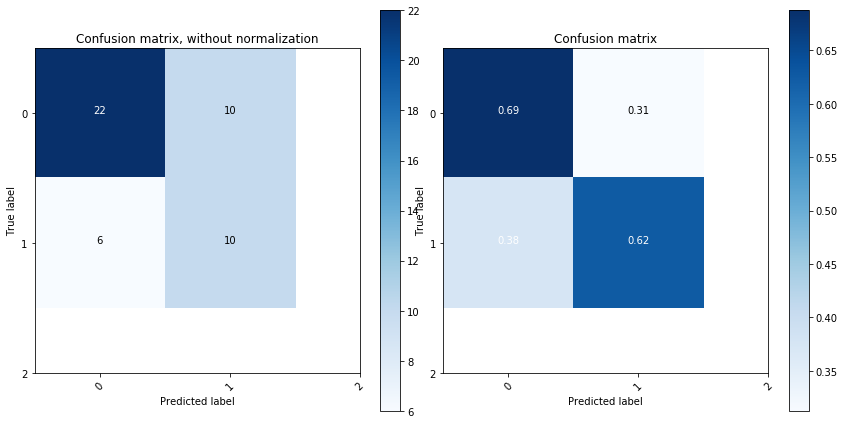

In [251]:
eval_plot(response_df['avg_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[19 13]
 [ 2 14]]
Normalized confusion matrix
[[0.59375 0.40625]
 [0.125   0.875  ]]


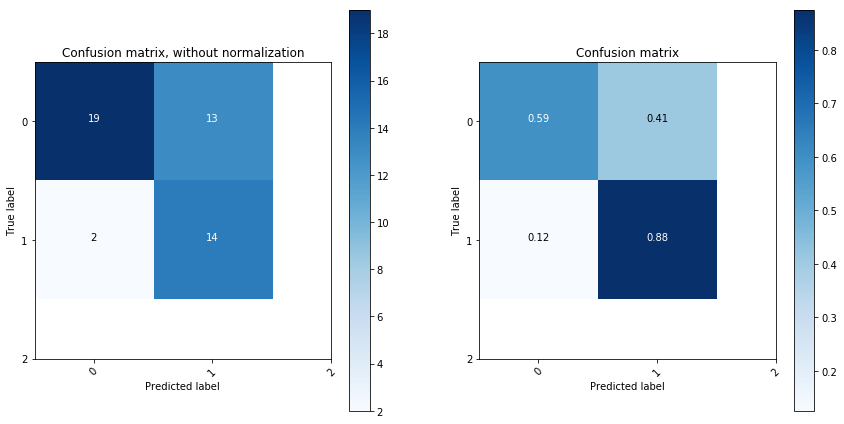

In [77]:
eval_plot(response_df['idf_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 4 12]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.25   0.75  ]]


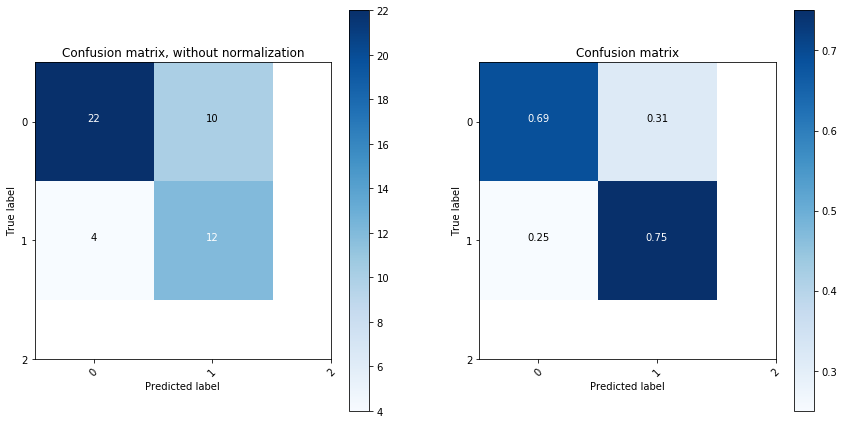

In [78]:
eval_plot(response_df['net_sim'], response_df['true_label'])

In [21]:
def encode_sentence(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    if next(nli_net.parameters()).is_cuda:
        s_batch = Variable(s_batch.cuda())
    else:
        s_batch = Variable(s_batch)
    encode = nli_net.encode((s_batch, s_len))
    return encode.cpu().data[0]

def encode_sentence_with_weight(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    if next(nli_net.parameters()).is_cuda:
        s_batch = Variable(s_batch.cuda())
    else:
        s_batch = Variable(s_batch)
    encode = nli_net.encode((s_batch, s_len))
    return encode.cpu().data[0], weight.cpu().data[0]

def cosScore_onePair(s1, s2):
    arr1 = encode_sentence(s1).reshape(1, -1)
    arr2 = encode_sentence(s2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

In [134]:
s = ['都 快 一个月 没有 到账', '都 快 一个月 没有 到账 都 快 一个月 没有 到账']
s_batch, s_len = get_inds_batch(s, word2ind)
s_batch = Variable(s_batch.cuda())

attention = nn.Linear(512, 1).cuda()
bilinear = nn.Bilinear(512, 512, 10, bias=False).cuda()

In [193]:
sent_output = nli_net.encode((s_batch, s_len))

In [195]:
sent_output.size()

torch.Size([2, 512])

In [53]:
padded_out_gru, lengths = pad_packed_sequence(sent_output, padding_value=int(0), batch_first=True)

In [59]:
similarity = padded_out_gru[0].mm(padded_out_gru[1].transpose_(0,1))

In [60]:
similarity

tensor([[141.5133, 120.1806,  92.6571,  72.2963,  22.2705,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [128.5665, 163.4691, 128.9526,  97.2106,  45.1070,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [114.4857, 139.0198, 157.0203, 108.1254,  60.5277,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [115.3453, 139.5762, 139.2273, 162.8483,  90.9356,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [ 96.5295, 117.8252, 120.9609, 116.0583, 149.8879,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [134.5546, 144.8269, 136.0316, 130.1129, 115.7858,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [118.3060, 156.5895, 149.4713, 140.6051, 121.0728,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [ 94.6881, 127.9626, 163.6716, 140.3012, 121.3994,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [ 67.0423, 103.0839, 121.3204, 172.6156,

In [163]:
import torch.nn.functional as F

convs = nn.ModuleList([
    nn.Conv2d(1, 64, [window_size, 300], padding=(window_size - 1, 0)).cuda()
    for window_size in [2,3,4]
])
print(convs)

ModuleList(
  (0): Conv2d(1, 64, kernel_size=[2, 300], stride=(1, 1), padding=(1, 0))
  (1): Conv2d(1, 64, kernel_size=[3, 300], stride=(1, 1), padding=(2, 0))
  (2): Conv2d(1, 64, kernel_size=[4, 300], stride=(1, 1), padding=(3, 0))
)


In [156]:
embed = nli_net.encode((s_batch, s_len))

In [158]:
embed[0].contiguous()

tensor([[[ 1.0486,  0.0664, -2.4765,  ...,  0.9040,  0.2748,  0.6418],
         [ 1.0486,  0.0664, -2.4765,  ...,  0.9040,  0.2748,  0.6418]],

        [[ 0.7739,  0.4152, -1.6381,  ..., -1.0803, -0.6725, -0.7733],
         [ 0.7739,  0.4152, -1.6381,  ..., -1.0803, -0.6725, -0.7733]],

        [[ 1.0913,  0.1706, -1.5071,  ..., -0.3930, -0.0911, -0.7894],
         [ 1.0913,  0.1706, -1.5071,  ..., -0.3930, -0.0911, -0.7894]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0913,  0.1706, -1.5071,  ..., -0.3930, -0.0911, -0.7894]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0711, -1.3048, -1.0099,  ..., -0.2505, -0.1931, -0.5480]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2405,  0.1570,  0.7707,  ..., -1.9165,  0.8437, -0.0129]]],
       device='cuda:0', grad_fn=<CloneBackward>)

In [191]:
x = embed[0].contiguous().transpose_(0,1)
x = torch.unsqueeze(x, 1)       # [B, C, T, E] Add a channel dim.
xs = []
for conv in convs:
    x2 = F.relu(conv(x))        # [B, F, T, 1]
    x2 = torch.squeeze(x2, -1)  # [B, F, T]
    x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
    xs.append(x2)
x = torch.cat(xs, 2)        
x = x.view(x.size(0), -1)

In [393]:
w = nn.Parameter(Variable(torch.FloatTensor([[1., -1.], [1., -1.]]), requires_grad=True)).cuda()
x = Variable(torch.FloatTensor([[2],[5]])).cuda()
pred = w.mm(x)
y = Variable(torch.FloatTensor([[1],[0]])).cuda()

In [394]:
loss = nn.MSELoss()
# input = torch.randn(3, 5, requires_grad=True)
# arget = torch.randn(3, 5)
output = loss(pred, y)
print(output)
output.backward()

tensor(12.5000, device='cuda:0', grad_fn=<MseLossBackward>)


In [339]:
hidden0 = torch.zeros(1, 1, 4).cuda()
hidden0 = nn.Parameter(hidden0, requires_grad=True)

In [342]:
hidden0

Parameter containing:
tensor([[[0., 0., 0., 0.]]], device='cuda:0', requires_grad=True)